In [1]:
import popeye

In [2]:
import ctypes, multiprocessing

In [3]:
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus
import popeye.og as og

In [4]:
from scipy.io import loadmat

# Load .mat file
img_data = loadmat('Stimuli/bar_stimulus_masks_1300ms_images.mat')

In [5]:
I = img_data["images"]

In [6]:
params_data = loadmat('Stimuli/bar_stimulus_masks_1300ms_params.mat')

In [7]:
P = params_data["stimulus"]

In [8]:
stimulus = VisualStimulus(I, 50, 25, 0.25, 1.0, ctypes.c_int16)

In [9]:
model = og.GaussianModel(stimulus, utils.double_gamma_hrf)

In [12]:
model

In [14]:
x = -5.24
y = 2.58
sigma = 1.24
hrf_delay = 2.0
beta = 0.55
baseline = -0.88

In [16]:
data = model.generate_prediction(x, y, sigma, hrf_delay, beta, baseline)

NotImplementedError: You must set the HRF delay to generate the HRF

In [2]:
import datetime

The gridfit solution was [-10.           0.           5.25         0.           0.71085094
   0.44636249], starting gradient descent ...
VOXEL=(001,002,003)   TIMEMS=1015   RSQ=0.73  EST=[ 2.7069  6.3052  4.3558 -0.306   0.8496 -2.408 ]
popeye will analyze 3 voxels across 3 cores


AttributeError: Can't pickle local object 'ProcessBackend.StorageFactory.<locals>.<lambda>'

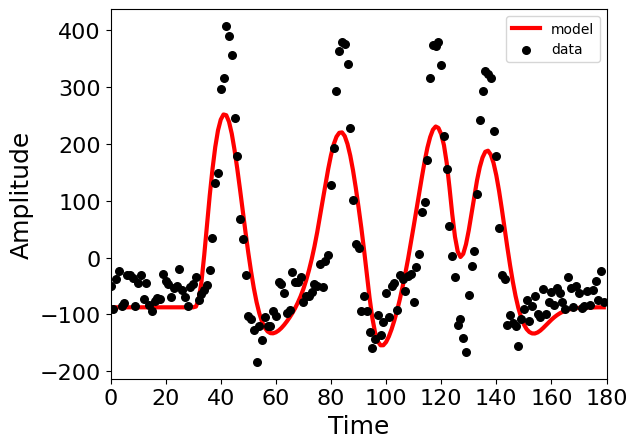

In [5]:
import ctypes, multiprocessing
import numpy as np
import sharedmem
import popeye.og_hrf as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus

# seed random number generator so we get the same answers ...
np.random.seed(2764932)

### STIMULUS
## create sweeping bar stimulus
sweeps = np.array([-1,0,90,180,270,-1]) # in degrees, -1 is blank
bar = simulate_bar_stimulus(100, 100, 40, 20, sweeps, 30, 30, 10)

## create an instance of the Stimulus class
stimulus = VisualStimulus(bar, 50, 25, 0.50, 1.0, ctypes.c_int16)

### MODEL
## initialize the gaussian model
model = og.GaussianModel(stimulus, utils.double_gamma_hrf)

## generate a random pRF estimate
x = -5.24
y = 2.58
sigma = 1.24
hrf_delay = -0.25
beta = 0.55
baseline = -0.88

## create the time-series for the invented pRF estimate
data = model.generate_prediction(x, y, sigma, hrf_delay, beta, baseline)

## add in some noise
data += np.random.uniform(-data.max()/10,data.max()/10,len(data))

### FIT
## define search grids
# these define min and max of the edge of the initial brute-force search. 
x_grid = (-10,10)
y_grid = (-10,10)
s_grid = (1/stimulus.ppd + 0.25,5.25)
h_grid = (-1.0,1.0)

## define search bounds
# these define the boundaries of the final gradient-descent search.
x_bound = (-12.0,12.0)
y_bound = (-12.0,12.0)
s_bound = (1/stimulus.ppd, 12.0) # smallest sigma is a pixel
b_bound = (1e-8,None)
u_bound = (None,None)
h_bound = (-3.0,3.0)

## package the grids and bounds
grids = (x_grid, y_grid, s_grid, h_grid)
bounds = (x_bound, y_bound, s_bound, h_bound, b_bound, u_bound,)

## fit the response
# auto_fit = True fits the model on assignment
# verbose = 0 is silent
# verbose = 1 is a single print
# verbose = 2 is very verbose
fit = og.GaussianFit(model, data, grids, bounds, Ns=3,
                     voxel_index=(1,2,3), auto_fit=True,verbose=2)

## plot the results
import matplotlib.pyplot as plt
plt.plot(fit.prediction,c='r',lw=3,label='model',zorder=1)
plt.scatter(range(len(fit.data)),fit.data,s=30,c='k',label='data',zorder=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
plt.xlim(0,len(fit.data))
plt.legend(loc=0)

## multiprocess 3 voxels
data = [data,data,data]
indices = ([1,2,3],[4,6,5],[7,8,9])
bundle = utils.multiprocess_bundle(og.GaussianFit, model, data, 
                                   grids, bounds, indices, 
                                   auto_fit=True, verbose=1, Ns=3)

## run
print("popeye will analyze %d voxels across %d cores" %(len(bundle), 3))
with sharedmem.Pool(np=3) as pool:
    t1 = datetime.datetime.now()
    output = pool.map(utils.parallel_fit, bundle)
    t2 = datetime.datetime.now()
    delta = t2-t1
    print("popeye multiprocessing finished in %s.%s seconds" %(delta.seconds,delta.microseconds))
